In [1]:
import h5py as hp
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import illustris_python as il
import matplotlib.gridspec as gspec
import matplotlib as mpl
import copy
tngpath = '/lustre/cosinga/L75n1820TNG/'
basepath = '/lustre/cosinga/hcolor/fig_md_analysis/'

In [2]:
slcfile = hp.File(basepath+'all_auto/HIslices.hdf5', 'r')
print(slcfile.keys())

<KeysViewHDF5 ['0 0 0 x', '0 0 0 y', '0 0 0 z', '0 1 0 x', '0 1 0 y', '0 1 0 z', '1 0 0 x', '1 0 0 y', '1 0 0 z', '1 1 0 x', '1 1 0 y', '1 1 0 z', '2 0 0 x', '2 0 0 y', '2 0 0 z', '2 1 0 x', '2 1 0 y', '2 1 0 z']>


In [3]:
# def loadfigArr(infile):
#     keys = list(infile.keys())
#     for k in keys:
        

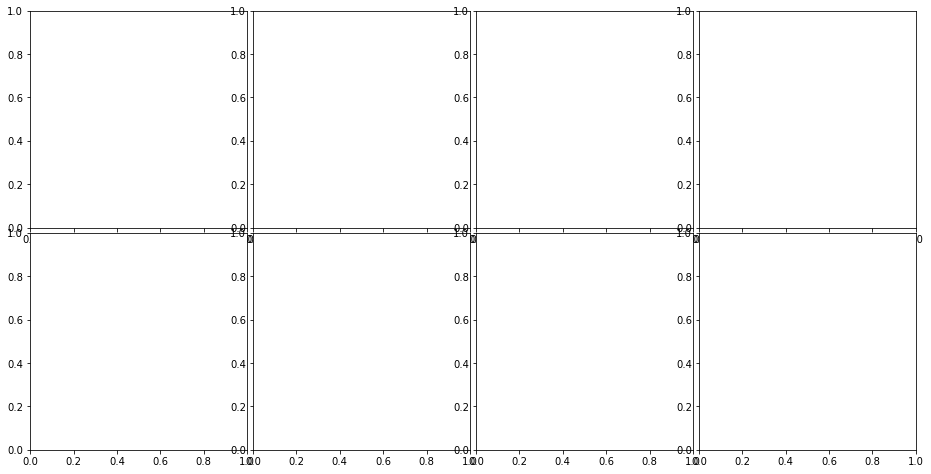

In [4]:
nrows = 2
ncols = 4
xborder = 1
yborder = 1
panel_bt = 0.1
panel_length = 3


# border input can be either a list or single number
if isinstance(xborder, float) or isinstance(xborder, int):
    xborder = [xborder, xborder]
if isinstance(yborder, float) or isinstance(yborder, int):
    yborder = [yborder, yborder]
if isinstance(panel_bt, float) or isinstance(panel_bt, int):
    panel_bt = [panel_bt, panel_bt]
# creating Figure object

figwidth = panel_length * ncols + panel_bt[0] * (ncols - 1) + \
        xborder[0] + xborder[1]
figheight = panel_length * nrows + panel_bt[1] * (nrows - 1) + \
        yborder[0] + yborder[1]

fig = plt.figure(figsize=(figwidth, figheight))

# creating gridspec
gs = gspec.GridSpec(nrows, ncols)
plt.subplots_adjust(left= xborder[0]/figwidth, right=1-xborder[1]/figwidth,
        top=1-yborder[1]/figheight, bottom=yborder[0]/figheight,
        wspace=panel_bt[0]*ncols/figwidth, hspace=panel_bt[1]*nrows/figheight)

# making panels list
panels = []
for i in range(nrows):
    col_panels = []
    for j in range(ncols):
        col_panels.append(fig.add_subplot(gs[i, j]))

    panels.append(col_panels)

In [5]:
from hc_lib.plots.fig_lib import FigureLibrary

flib= FigureLibrary(fig = fig, panels = panels)
flib.panel_length = panel_length
flib.panel_bt = panel_bt
flib.xborder = xborder
flib.yborder = yborder
flib.figsize = [figwidth, figheight]

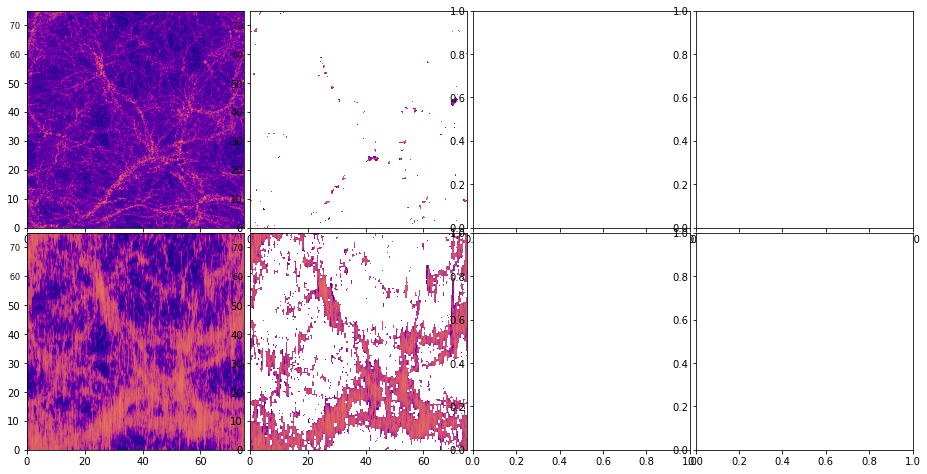

In [6]:
flib.assignSliceNorms()
flib.assignColormaps(under='w')
# top left panel is vn real space
idx = '2 0 0 '
data = slcfile[idx+'z'][:]
xlim = slcfile[idx+'x'][:]
ylim = slcfile[idx+'y'][:]
flib.plotSlicePanel((0,0), data, xlim, ylim)

# top middle panel is hiptl real space
idx = '0 0 0 '
data = slcfile[idx+'z'][:]
xlim = slcfile[idx+'x'][:]
ylim = slcfile[idx+'y'][:]
flib.plotSlicePanel((0,1), data, xlim, ylim)

# bottom left is vn redshift space
idx = '2 1 0 '
data = slcfile[idx+'z'][:]
xlim = slcfile[idx+'x'][:]
ylim = slcfile[idx+'y'][:]
flib.plotSlicePanel((1,0), data, xlim, ylim)

# bottom middle is hiptl redshift space
idx = '0 1 0 '
data = slcfile[idx+'z'][:]
xlim = slcfile[idx+'x'][:]
ylim = slcfile[idx+'y'][:]
flib.plotSlicePanel((1,1), data, xlim, ylim)

fig

In [7]:
f = il.groupcat.loadSubhalos(tngpath+'output/',99, fields=['SubhaloPos', 'SubhaloVel'])
h = hp.File(tngpath+'postprocessing/hih2/hih2_galaxy_099.hdf5', 'r')
head = il.groupcat.loadHeader(tngpath+'output/',99)
ids = h['id_subhalo'][:]
ids = ids.astype(np.int32)
pos = f['SubhaloPos'][ids] / 1e3 * head['Time']
vel = f['SubhaloVel'][ids]
box = head['BoxSize']/1e3*head['Time']
mnm = box/2 - box * 0.1
mxm = box/2 + box * 0.1
pos_mask = (pos[:,1]> mnm) & (pos[:,1]<mxm)
x = pos[pos_mask, 2]
y = pos[pos_mask, 0]
mass=h['m_hi_GD14_map'][pos_mask]
norm = flib.norm_arr[0,0]
cmap = flib.cmap_arr[0,0]
sm = mpl.cm.ScalarMappable(norm = norm, cmap = cmap)
sizes = np.log10(mass)
colors = np.zeros((sizes.shape[0],4))
for s in range(len(sizes)):
    colors[s,:] = sm.to_rgba(sizes[s])
sizes = mass/np.max(mass)


/software/spack-software/2020.05.14/linux-rhel8-ivybridge/gcc-8.4.0/python-3.7.7-zgcjuclie3fiis4ljkrfp4c4j6fkoa62/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


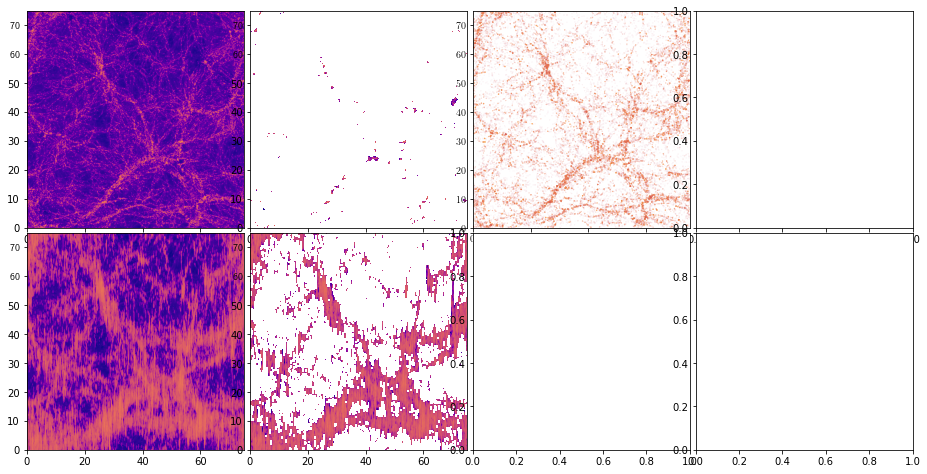

In [8]:

panels[0][2].clear()
panels[0][2].scatter(x, y, s=sizes, c=colors)
panels[0][2].set_ylim(ylim[0], ylim[1])
panels[0][2].set_xlim(xlim[0], xlim[1])
fig

In [9]:
hubble = head["HubbleParam"]*100 # defined using big H
redshift = head['Redshift']
boxsize = box
factor = (1+redshift)/hubble
rspos = copy.copy(pos)
rspos[:,0] += vel[:,0]*factor

# handle periodic boundary conditions
rspos[:, 0] = np.where((rspos[:,0]>boxsize) | (rspos[:,0]<0), 
        (rspos[:,0]+boxsize)%boxsize, rspos[:,0])

In [10]:
rspos_mask = (rspos[:,1]> mnm) & (rspos[:,1]<mxm)
x = rspos[rspos_mask, 2]
y = rspos[rspos_mask, 0]
mass=h['m_hi_GD14_map'][rspos_mask]
norm = flib.norm_arr[0,0]
cmap = flib.cmap_arr[0,0]
sm = mpl.cm.ScalarMappable(norm = norm, cmap = cmap)
sizes = np.log10(mass)
colors = np.zeros((sizes.shape[0],4))
for s in range(len(sizes)):
    colors[s,:] = sm.to_rgba(sizes[s])
sizes = mass/np.max(mass)

/software/spack-software/2020.05.14/linux-rhel8-ivybridge/gcc-8.4.0/python-3.7.7-zgcjuclie3fiis4ljkrfp4c4j6fkoa62/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


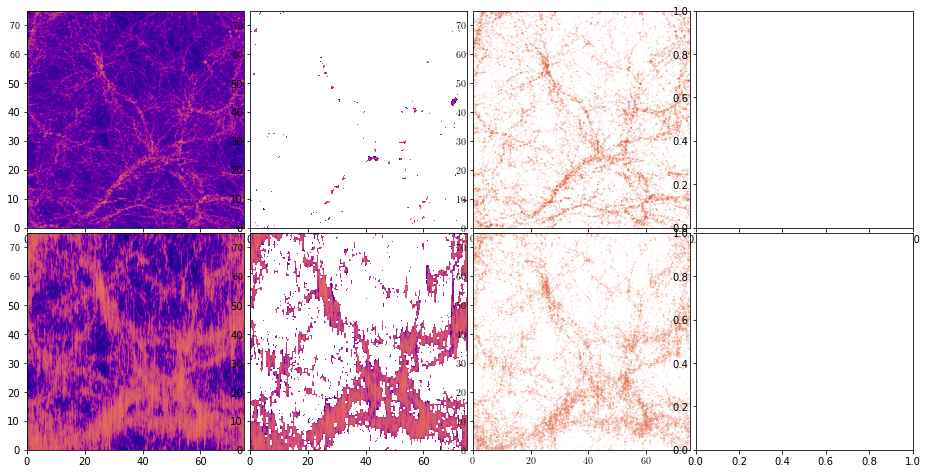

In [11]:
panels[1][2].clear()
panels[1][2].scatter(x, y, s=sizes, c=colors)
panels[1][2].set_ylim(ylim[0], ylim[1])
panels[1][2].set_xlim(xlim[0], xlim[1])
fig

In [12]:
cax = panels[0][3]
cax.set_aspect(12, anchor='W')
cbar = fig.colorbar(sm, cax=cax)
cax = panels[1][3]
cax.set_aspect(12, anchor='W')
cbar = fig.colorbar(sm, cax=cax)

In [13]:
flib.has_cbar_col = True
flib.addRowLabels(['Real Space', 'Redshift Space'], color='white')
flib.addColLabels(['VN18-Particle', 'D18-Particle', 'D18-Subhalo', ''], fsize=12)
cbar_panels = [(0,3),(1,3)]
flib.removeYTickLabels(panel_exceptions=cbar_panels + [(0,0),(1,0)])
flib.removeXTickLabels()
flib.changeTickDirection(panel_exceptions=cbar_panels)
image_length = (ncols-1) * panel_length + \
        panel_bt[0] * (ncols - 1)

hpos = (0.5 * image_length + xborder[0]) / flib.figsize[0]
flib.axisLabel('x (Mpc/h)', 'x', pos = [hpos, yborder[1]/3/figheight])


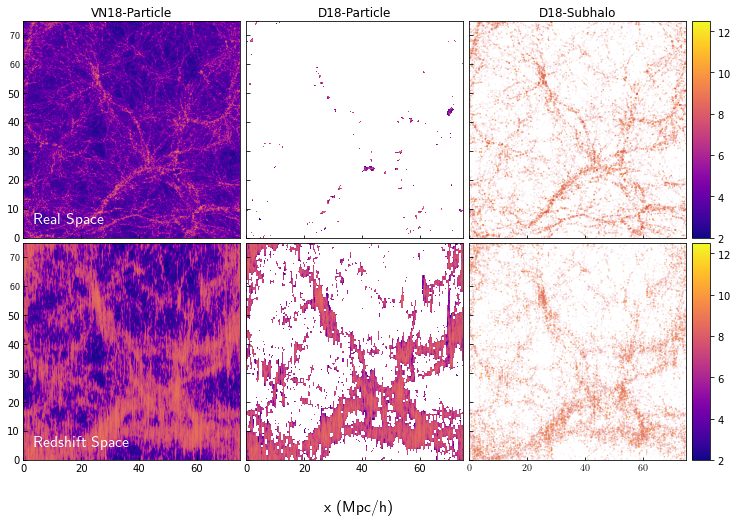

In [14]:
fig

In [15]:
cbarpos = ((figwidth - 1.05*panel_length)/figwidth, 0.5)
flib.axisLabel('log M$_{\mathrm{HI}}$/M$_\odot$', '', pos=cbarpos, rotation = 'vertical', fsize=16)

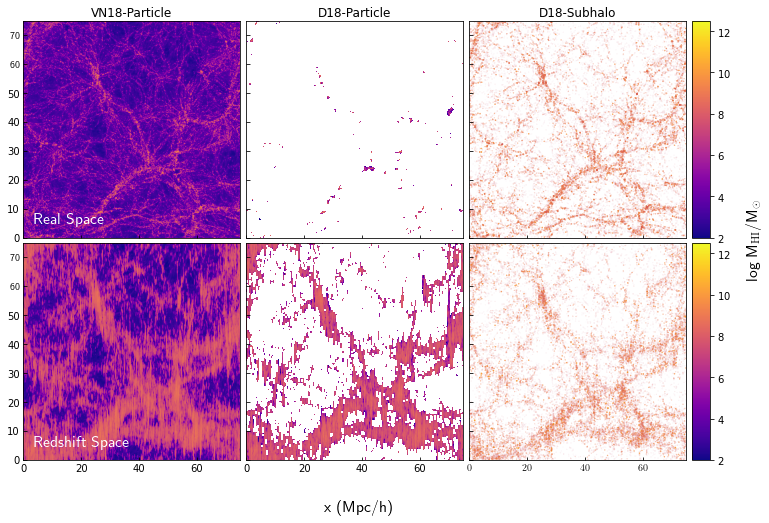

In [16]:
fig

In [17]:
fig.savefig('HI_methodology_slices.png')